# Ornstein Uhlenbeck Instanton Calculation 

In this notebook we will use the MAM method outlined in [1] to calculate an instanton in the Ornstein Uhlenbeck SDE model. We will compare this to the analytic solution as well as the numerically integrated Euler-Lagrange Equations.

- [1] Weinan, E., Ren, W. and Vanden-Eijnden, E., 2004. Minimum action method for the study of rare events. Communications on pure and applied mathematics, 57(5), pp.637-656.

In [1]:
# Standard Package imports

import numpy as np
import numpy.linalg as la
import numpy.random as rm
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy.optimize import minimize
from scipy.optimize import show_options
from scipy.stats import gaussian_kde

## Model Definition

The SDE is defined via 

$dx = -\gamma x dt  + \sigma dWt$

In [2]:
def a(t, x, s):
    gamma, sigma = s
    return - gamma * x

def b(t, x, s):
    gamma, sigma = s
    return sigma

def euler_maruyama(a,b,s,x0,t):
    """ x0 shape is [ensemble member, dim]
    return x shape is [time, ensemble member, dim]
    """
    N = len(t)
    x = np.zeros(np.append(N, x0.shape))
    x[0] = x0
    for i in tqdm(range(N-1)):
        dt = t[i+1]-t[i]
        dWt = rm.normal(0, np.sqrt(dt))
        x[i+1] = x[i] + a(t[i], x[i], s) * dt + b(t[i], x[i], s) * dWt
    return x

## Model Run

In [3]:
# Parameter Specification

# OU Parameters
gamma = 0.5
sigma = 0.25
s = [gamma, sigma]
D = sigma **2

# Time
t0 = 0
tF = 100
dt = 0.01
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

## Model Definition

The SDE is defined via 

$dx = -\gamma x dt  + \sigma dWt$

In [4]:
def a(t, x, s):
    gamma, sigma = s
    return - gamma * x

def b(t, x, s):
    gamma, sigma = s
    return sigma

def euler_maruyama(a,b,s,x0,t):
    """ x0 shape is [ensemble member, dim]
    return x shape is [time, ensemble member, dim]
    """
    N = len(t)
    x = np.zeros(np.append(N, x0.shape))
    x[0] = x0
    for i in tqdm(range(N-1)):
        dt = t[i+1]-t[i]
        dWt = rm.normal(0, np.sqrt(dt))
        x[i+1] = x[i] + a(t[i], x[i], s) * dt + b(t[i], x[i], s) * dWt
    return x

In [5]:
# Initial Conditions

ensemble_size = 1000
x_ic  = rm.normal(0, size=ensemble_size)

In [6]:
run = euler_maruyama(a,b,s,x_ic,time) #[time, ensemble member]

## Plotting Output

In [7]:
# KDE PDFs

run_data = run[100:].flatten()
kde = gaussian_kde(run_data)
x_range = np.linspace(run_data.min() - 0.5, run_data.max() + 0.5)
pdf = kde.evaluate(x_range)

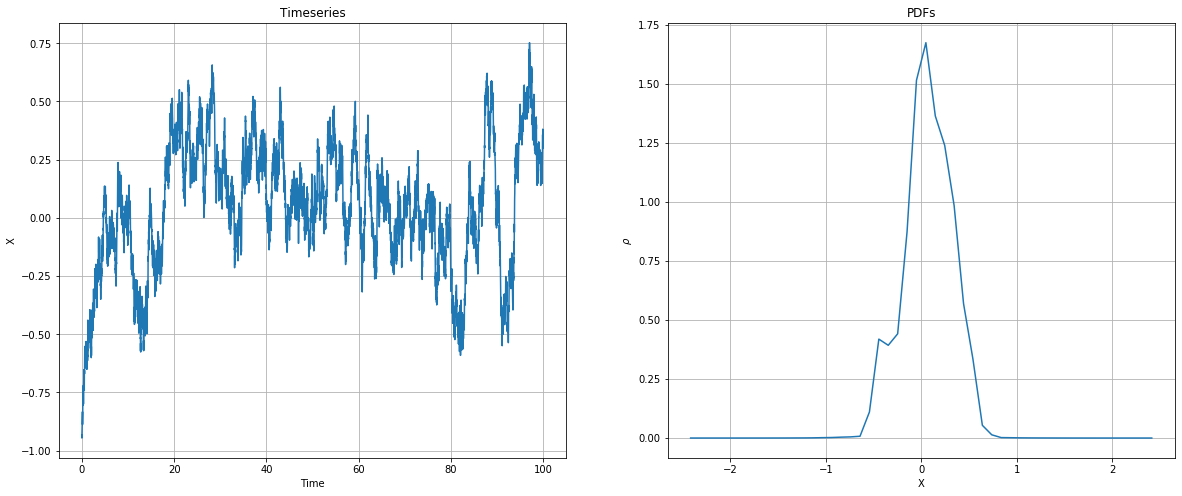

In [8]:
# PDF and Timeseries Plot

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

titles = ['Timeseries', 'PDFs']
x_labels = ['Time', 'X']
y_labels = ['X', '$\\rho$']

x_data = [time, x_range]
y_data = [run[:, 0], pdf]

for i, ax in enumerate(axes):
    ax.grid()
    ax.plot(x_data[i], y_data[i])
    ax.set_title(titles[i])
    ax.set_xlabel(x_labels[i])
    ax.set_ylabel(y_labels[i])

# F-W Action Minimisation

In [9]:
# F-W action Definition

def a(t, x, s):
    gamma, sigma = s
    return - gamma * x

def action(phi, a=a, args=[s, dt]):
    """
    - phi is path we calculate action over
    - a is detemrinistic part of SDE
    - s are SDE parameters
    
    returns F-W action approximation where finite differences 
    are used to approximate the derivatives and integral.
    """
    v = np.gradient(phi, dt) -  a(0, phi, s)
    integrand =  v**2
    return 0.5 * np.trapz(integrand, dx=dt)

In [10]:
def analytic_solution(time, x0, xf, s=s):
    gamma, sigma = s
    t0 = time[0]
    tf = time[-1]
    c1 = (xf - x0 * np.exp(- gamma * tf))/(2 * np.sinh(gamma * tf))
    c2 = x0 - c1
    return c1 * np.exp(gamma * time) + c2 * np.exp(-gamma * time)

In [17]:
# Parameter Specification

# OU Parameters
gamma = 0.5
sigma = 0.25
s = [gamma, sigma]
D = sigma **2

# Time
t0 = 0
tF = 10
dt = 0.1
steps = int((tF-t0)/dt)
time = np.arange(t0, tF, dt)

In [24]:
# Instanton Initialisation

initial_point = 0.1
final_point = 1.1

inst_ic = np.linspace(initial_point, final_point, len(time))

## Minimisation

In [26]:
# Bounds on action arguments

def bounds(steps, initial_point, final_point):
    bnds = np.zeros((steps, 2))
    bnds[0]= [initial_point-0.1, initial_point]
    bnds[1:-1, 0] = initial_point-0.1 # when this is 0, something funny in the solution
    bnds[1:-1, 1] = final_point+0.1
    bnds[-1]= [final_point, final_point+0.1]
    return bnds

bnds = bounds(steps, initial_point, final_point)

In [20]:
ls_max = 10 # max number of linesearch steps
it_max = 1000000 # max number of iterations

In [21]:
res = minimize(action, inst_ic, method='L-BFGS-B', bounds = bnds, 
               options={'maxls': ls_max, 'maxiter': it_max, 'maxfun': it_max})
print(res.message)

b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'


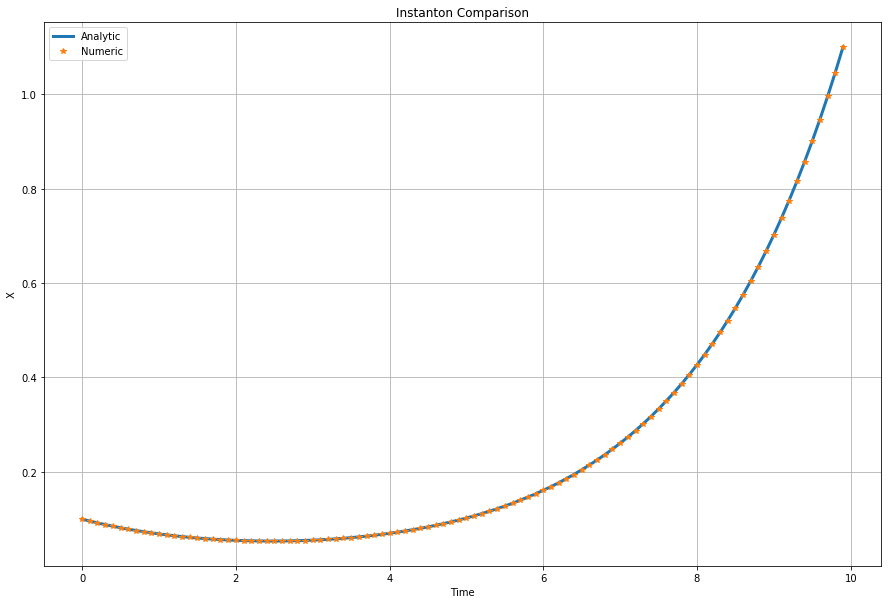

In [22]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(time, analytic_solution(time, initial_point, final_point),linewidth=3,label='Analytic')
ax.plot(time, res.x,'*',label='Numeric')
ax.grid()
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('X')
ax.set_title('Instanton Comparison')
fig.show()